### This notebook is to solve the optimal route for two companies and one vehicle(uncapacitated). Suppose all passengers from company 1 must be pickuped before the arrival of company 1. And company 2 is the final destination.

In [1]:
# coding: utf-8

from pulp import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
# generate locations of each sites
def generate_sites(num_customer_sites):
    sites = list(np.arange(0, num_customer_sites + 3))
    sdtlist1 = []
    sdtlist2 = []

    # create distance matrix
    d_matrix = np.zeros((len(sites), len(sites)))

    # random generate points
    # np.random.seed(123)
    positions = dict((a, (np.random.rand() - .5, np.random.rand() - .5)) for a in sites)
    
    # org
    positions[0] = (0, 0)
    
    # pick up nodes
    positions[1] = (-0.2, -0.05)
    positions[2] = (-0.25, 0.15)
    positions[3] = (0.3, 0.25)
    positions[4] = (-0.05, 0.3)
    positions[5] = (-0.25,-0.15)
    positions[6] = (0.25, 0.45)
    positions[7] = (0.45, 0.1)
    
    # destinations
    positions[8] = (-0.2, 0.3)
    positions[9] = (0.3, 0.3)

    # plot it
    for s in positions:
        p = positions[s]
        plt.plot(p[0], p[1], 'o')
        plt.text(p[0] + .01, p[1], s, horizontalalignment='left', verticalalignment='center')
    plt.gca().axis('off');
    plt.show()

    # a function for computing distance between two points
    d = lambda p1, p2: np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

    # calculate all the pairs
    for idx1, s1 in enumerate(positions):
        for idx2, s2 in enumerate(positions):
            if s1 != s2:
                d_matrix[idx1, idx2] = d(positions[s1], positions[s2])
    # print(d_matrix)

    for i in range(1,5):
        sdtlist1.append(d(positions[i], positions[8]))
    for j in range(5,8):
        sdtlist2.append(d(positions[j], positions[9]))

    return sites,d_matrix,positions,sdtlist1, sdtlist2

In [3]:
def visualize_result(non_zero_edges,sites,positions):
    # In[488]:

    def get_next_site(parent):
        '''helper function to get the next edge'''
        edges = [e for e in non_zero_edges if e[0]== parent]
        # print (edges)
        # for e in edges:
        #     non_zero_edges.remove(e)
        return edges

    tours = get_next_site(0)
    # print (tours)
    tours = [ [e] for e in tours ]
    n = 1
    for t in tours:
        while n < len(sites)-1:
            if t[-1][1] != 0:
                # print (t[-1][1])
                t.append(get_next_site(t[-1][1])[-1])
                n +=1

    # The optimal tours:
    for t in tours:
        print(' -> '.join([ str(a) for a,b in t]+['9']))

    #draw the tours
    colors = [np.random.rand(3) for i in range(len(tours))]
    for t,c in zip(tours,colors):
        for a,b in t:
            p1,p2 = positions[a], positions[b]
            plt.plot([p1[0],p2[0]],[p1[1],p2[1]], color=c)

    #draw the map again
    for s in positions:
        p = positions[s]
        plt.plot(p[0],p[1],'o')
        plt.text(p[0]+.01,p[1],s,horizontalalignment='left',verticalalignment='center')

    plt.gca().axis('off');
    plt.show()

### At first, I generated 10 pickup nodes, but it took a long time for the computer to find the optimal result, so I instead generated 7 pickup nodes. Nodes 1,2,3,4 are for company 1, and nodes 5,6,7 are for company 2. 
### 0 represents the depot, 8 represents company1, 9 represents company 2.

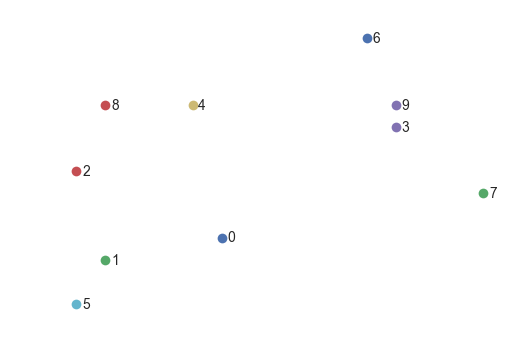

F:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
F:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
F:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it conta

In [4]:
num_customer_sites = 7
K = 1  # the number of shuttles
staytime = 1
M = 9999
speed = 0.05
sdtime1 = []
sdtime2 = []

# geneate sites
sites, d_matrix, positions,sdtlist1,sdtlist2 = generate_sites(num_customer_sites)
for a in range(0,len(sdtlist1)):
    sdtime1.append(sdtlist1[a]/speed)
for a in range(0, len(sdtlist2)):
    sdtime2.append(sdtlist2[a] / speed)

standardized_sdtime1 = StandardScaler().fit_transform(sdtime1)
standardized_sdtime2 = StandardScaler().fit_transform(sdtime2)

avg_d_matrix = d_matrix.mean()
std_d_matrix = d_matrix.std()
standardized_d_matrix = StandardScaler().fit_transform(d_matrix)

#generate indices for distance matrix
X,Y = np.meshgrid( np.arange(len(sites)), np.arange(len(sites)) )
matrix_coordinate_list = []
for coor in zip(X.flatten(),Y.flatten()):
    matrix_coordinate_list.append(coor)

t_matrix = d_matrix/speed
avg_t_matrix = t_matrix.mean()
std_t_matrix = t_matrix.std()
standardized_t_matrix = StandardScaler().fit_transform(t_matrix)

In [5]:
#create the problme
prob=LpProblem("transpotation",LpMinimize)

# indicator variable if site i is connected to site j in the tour
x = LpVariable.dicts('x', (sites,sites), 0, 1, LpBinary)
# indicator variable to eliminate subtours
z = LpVariable.dicts('z', sites, 0, num_customer_sites, LpInteger)
# start time at each node
s = LpVariable.dicts('s', sites, 0, None , LpContinuous)
# the maximum difference between self-driving time and shuttle time    
u = LpVariable('u', 0, None ,LpContinuous)

dist = sum([x[r][c] * standardized_d_matrix[r, c] for (r, c) in matrix_coordinate_list])

avgtime1 =  sum([s[8] - s[i] for i in range(1,len(s)-5)])
avgtime2 = sum([s[9] - s[i] for i in range(5,len(s)-2)])
avgtime = (avgtime1 + avgtime2)/num_customer_sites

# Formulate the objective function
alpha = 0.5
beta = 0.5
gamma = 0.5
cost = lpSum(alpha * dist + beta * avgtime + gamma * u)
prob+=cost

In [6]:
# add constraints
# (1) the diagonal value of x matrix is 0
prob += lpSum([ x[r][c] for (r,c) in matrix_coordinate_list if r==c ]) == 0

# (2) org, node 1 - 5 can not go to des2
for (r, c) in matrix_coordinate_list:
    if c == 9 and (r == 0 or r == 1 or r == 2 or r == 3 or r == 4):
        prob += (lpSum([x[r][c]]) == 0)
        
# (3) org can not go to des1
prob += lpSum([x[r][c] for (r, c) in matrix_coordinate_list if r == 0 and c == 8]) == 0

# (4) des1 can not go to node 1 to node 5
for (r, c) in matrix_coordinate_list:
    if r == 8 and( c == 1 or c == 2 or c == 3 or c == 4 ):
        prob += (lpSum([x[r][c]]) == 0)
        
# (5) des2 is the finial visited node
prob += lpSum([x[r][c] for (r, c) in matrix_coordinate_list if r == 9]) == 0

# (6) no node can go to org
prob += lpSum([x[r][c] for (r, c) in matrix_coordinate_list if c == 0]) == 0

# (7) each node is visted only once
for i in range(0, len(sites)-1):
    prob += lpSum([ x[r][c] for (r,c) in matrix_coordinate_list if r== i ]) == 1
    
# (8) each node is visited only once
for i in range(1, len(sites)):
    prob += lpSum([ x[r][c] for (r,c) in matrix_coordinate_list if c== i ]) == 1
    
# (9) no circular route
prob += (lpSum([x[r][c] + x[c][r] for (r,c) in matrix_coordinate_list if r == c])) <= 1

# (10) subtour elimination
N=len(sites)/K
for i in sites:
    for j in sites:
        if i != j and (i != 0 and j!= 0 and i != 1 and j!= 1) and (i,j) in matrix_coordinate_list:
            prob += z[i] - z[j] <= (N)*(1-x[i][j]) - 2

# (11) start time is set correctly along the path
for (r, c) in matrix_coordinate_list:
    prob += s[c] - s[r] - standardized_t_matrix[r,c] + M*(1 - x[r][c])>= staytime
    
# (12) pick up all the passengers to des1 before arriving des1
for j in range(1, len(sites)-5):
        prob += s[len(sites)-2] - s[j] >= 0
# (13) node 9 is the last visited node
for k in range(0, len(sites)):
        prob += s[len(sites)-1] - s[k] >= 0
# (14) u constraint
for l in range(1,5):
    prob += u - (s[8]-s[l])+standardized_sdtime1[l-1] >= 0
for m in range(5,8):
    prob += u - (s[9] - s[m]) + standardized_sdtime2[m-5] >= 0

In [7]:
# The problem data is written to an .lp file
# prob.writeLP("my_problem.lp")
result = prob.solve()
print(LpStatus[prob.status])

# print solution
print(value(prob.objective))
# for v in prob.variables():
#     print(v.name, "=", v.varValue)

Optimal
0.95580946504


[(5, 1), (4, 2), (0, 3), (3, 4), (2, 5), (8, 6), (6, 7), (1, 8), (7, 9)]
0 -> 3 -> 4 -> 2 -> 5 -> 1 -> 8 -> 6 -> 7 -> 9


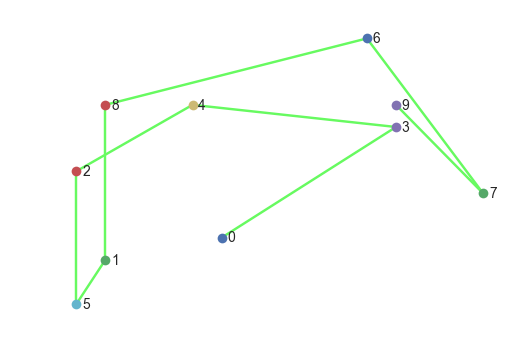

In [8]:
non_zero_edges = [ e for e in matrix_coordinate_list if value(x[e[0]][e[1]]) != 0 ]
print (non_zero_edges)

# see the result
visualize_result(non_zero_edges, sites, positions)


Results:

The start time at each node is: 
s_0 = 0.0
s_1 = 33.117385
s_2 = 22.881317
s_3 = 8.8102497
s_4 = 16.881317
s_5 = 29.881317
s_6 = 51.604218
s_7 = 60.666476
s_8 = 41.117385
s_9 = 66.666476
The optimal distance is:  2.8833238097
The optimal time is:  66.666476

u = 2.6242589
x_0_0 = 0.0
x_0_1 = 0.0
x_0_2 = 0.0
x_0_3 = 1.0
x_0_4 = 0.0
x_0_5 = 0.0
x_0_6 = 0.0
x_0_7 = 0.0
x_0_8 = 0.0
x_0_9 = 0.0
x_1_0 = 0.0
x_1_1 = 0.0
x_1_2 = 0.0
x_1_3 = 0.0
x_1_4 = 0.0
x_1_5 = 0.0
x_1_6 = 0.0
x_1_7 = 0.0
x_1_8 = 1.0
x_1_9 = 0.0
x_2_0 = 0.0
x_2_1 = 0.0
x_2_2 = 0.0
x_2_3 = 0.0
x_2_4 = 0.0
x_2_5 = 1.0
x_2_6 = 0.0
x_2_7 = 0.0
x_2_8 = 0.0
x_2_9 = 0.0
x_3_0 = 0.0
x_3_1 = 0.0
x_3_2 = 0.0
x_3_3 = 0.0
x_3_4 = 1.0
x_3_5 = 0.0
x_3_6 = 0.0
x_3_7 = 0.0
x_3_8 = 0.0
x_3_9 = 0.0
x_4_0 = 0.0
x_4_1 = 0.0
x_4_2 = 1.0
x_4_3 = 0.0
x_4_4 = 0.0
x_4_5 = 0.0
x_4_6 = 0.0
x_4_7 = 0.0
x_4_8 = 0.0
x_4_9 = 0.0
x_5_0 = 0.0
x_5_1 = 1.0
x_5_2 = 0.0
x_5_3 = 0.0
x_5_4 = 0.0
x_5_5 = 0.0
x_5_6 = 0.0
x_5_7 = 0.0
x_5_8 = 0.0
x_5_9 = 0.0
x_6_0 = 0.0
x_6_1 = 0.0
x_6_2 = 0.0
x_6_3 = 0.0
x_6_4 = 0.0
x_6_5 = 0.0
x_6_6 = 0.0
x_6_7 = 1.0
x_6_8 = 0.0
x_6_9 = 0.0
x_7_0 = 0.0
x_7_1 = 0.0
x_7_2 = 0.0
x_7_3 = 0.0
x_7_4 = 0.0
x_7_5 = 0.0
x_7_6 = 0.0
x_7_7 = 0.0
x_7_8 = 0.0
x_7_9 = 1.0
x_8_0 = 0.0
x_8_1 = 0.0
x_8_2 = 0.0
x_8_3 = 0.0
x_8_4 = 0.0
x_8_5 = 0.0
x_8_6 = 1.0
x_8_7 = 0.0
x_8_8 = 0.0
x_8_9 = 0.0
x_9_0 = 0.0
x_9_1 = 0.0
x_9_2 = 0.0
x_9_3 = 0.0
x_9_4 = 0.0
x_9_5 = 0.0
x_9_6 = 0.0
x_9_7 = 0.0
x_9_8 = 0.0
x_9_9 = 0.0
z_2 = 5.0
z_3 = 0.0
z_4 = 3.0
z_5 = 7.0
z_6 = 2.0
z_7 = 5.0
z_8 = 0.0
z_9 = 7.0